# 4.7 Design Deep Reinforcement Learning Agent
## Data Considerations 

In this notebook we will implement some of the considerations necessary to train this model on larger datasets in the scope of > gb. 

In order to do so, we will take the following steps:

1) Save datasets as TFDatasets   
2) Implement iteration on the TFDataset as most models prefer. This is important for distributed learning.   
3) Checkpoint and save models accordingly so they can be loaded again.  
4) Predict on evaluation data.  

#### Download datasets for all the stocks in the S&P 500.

In [3]:
from IPython import display
!pip install gcsfs
!pip install tf-agents[reverb]
display.clear_output()

In [4]:
from google.colab import drive
from google.cloud import storage
import pandas as pd
import time
import pandas as pd 
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function

import abc
import tensorflow as tf
import numpy as np
import base64
import IPython
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
import reverb

tf.compat.v1.enable_v2_behavior()

In [10]:
# drive.mount('/content/drive')

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/fin-aml/fin-aml-gcskeys-337dfd8d8867.json"

# storage_client = storage.Client()
# display.clear_output()

In [11]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

tempdir = tempfile.gettempdir()

In [12]:
# df = pd.read_csv('gs://fin-datasets-aml/data/sp500/spdfm.csv')
# df.set_index('datetime', inplace=True)
# df.head()

In [13]:
# create toy data to test whether the model works
# 311 time steps of a sine wave, X = 0:310, y = 311
# linspace 0 311 as columns
# rows of different unique waves in A, B, C, D
# maybe something like 5000 rows to start with
import numpy as np
feature_space = np.linspace(0, 311, 311).reshape(1, 311)

A = np.random.normal(0, .1, size=5000).reshape(5000,1)
B = np.random.normal(0, .1, size=5000).reshape(5000, 1)
C = np.random.normal(0, 3, size=5000).reshape(5000, 1)
D = np.random.normal(0, 100, size=5000).reshape(5000, 1)


Xy = np.sin(np.matmul(C, feature_space)*(2*np.pi) - D) * A + B
# X = np.matmul(, A) + B
# X.shape
Xy.shape

(5000, 311)

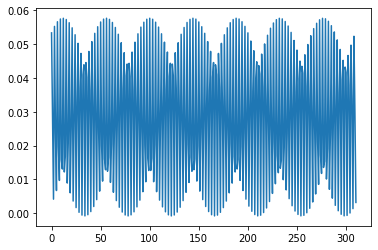

In [14]:
import matplotlib.pyplot as plt

plt.plot(Xy[3]);

In [15]:
import pandas as pd 

Xdf = pd.DataFrame(Xy)
Xdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310
0,-0.022668,-0.082719,0.003856,0.018789,-0.075568,-0.041327,0.035185,-0.038930,-0.076817,0.017043,0.006015,-0.082098,-0.025150,0.033285,-0.054117,-0.067002,0.027114,-0.009049,-0.084319,-0.008929,0.027052,-0.067090,-0.054009,0.033316,-0.025274,-0.082065,0.006122,0.016954,-0.076878,-0.038810,0.035183,-0.041446,-0.075503,0.018874,0.003746,-0.082747,-0.022543,0.032575,-0.056354,-0.065127,0.028374,-0.011581,-0.084260,-0.006428,0.025689,-0.068880,-0.051713,0.033910,-0.027880,-0.081301,...,-0.080845,-0.029279,0.034183,-0.050456,-0.069808,0.024916,-0.005097,-0.084181,-0.012953,0.029010,-0.064087,-0.057532,0.032149,-0.021143,-0.083051,0.002504,0.019825,-0.074756,-0.042787,0.035134,-0.037444,-0.077541,0.015934,0.007316,-0.081667,-0.026676,0.033649,-0.052780,-0.068063,0.026331,-0.007580,-0.084301,-0.010407,0.027804,-0.066004,-0.055327,0.032917,-0.023748,-0.082461,0.004802,0.018038,-0.076123,-0.040287,0.035198,-0.039977,-0.076285,0.017812,0.005082,-0.082381,-0.024070
1,-0.321897,-0.322885,-0.319117,-0.310858,-0.298696,-0.283494,-0.266332,-0.248428,-0.231054,-0.215442,-0.202703,-0.193740,-0.189190,-0.189376,-0.194284,-0.203567,-0.216565,-0.232355,-0.249816,-0.267708,-0.284760,-0.299762,-0.311649,-0.319576,-0.322980,-0.321621,-0.315593,-0.305326,-0.291549,-0.275239,-0.257555,-0.239752,-0.223095,-0.208766,-0.197784,-0.190927,-0.188682,-0.191210,-0.198330,-0.209537,-0.224035,-0.240795,-0.258627,-0.276263,-0.292453,-0.306046,-0.316078,-0.321835,-0.322910,-0.319225,...,-0.316316,-0.306403,-0.292904,-0.276776,-0.259164,-0.241320,-0.224510,-0.209929,-0.198610,-0.191358,-0.188689,-0.190791,-0.197515,-0.208384,-0.222626,-0.239230,-0.257016,-0.274722,-0.291091,-0.304960,-0.315344,-0.321506,-0.323009,-0.319746,-0.311947,-0.300169,-0.285245,-0.268237,-0.250352,-0.232860,-0.217003,-0.203907,-0.194502,-0.189455,-0.189126,-0.193537,-0.202376,-0.215014,-0.230554,-0.247893,-0.265800,-0.283003,-0.298280,-0.310547,-0.318932,-0.322841,-0.321996,-0.316456,-0.306615,-0.293172
2,0.002131,-0.002983,-0.001442,0.003385,0.000944,-0.003428,-0.000172,0.003593,-0.000365,-0.003392,0.001129,0.003314,-0.001615,-0.002881,0.002284,0.002588,-0.002634,-0.001964,0.003133,0.001513,-0.003282,-0.000769,0.003558,0.000238,-0.003470,0.000541,0.003501,-0.001061,-0.003171,0.001785,0.002971,-0.002206,-0.002427,0.002791,0.002039,-0.003039,-0.001341,0.003421,0.000835,-0.003444,-0.000061,0.003588,-0.000475,-0.003367,0.001235,0.003269,-0.001712,-0.002818,0.002370,0.002508,...,-0.000540,-0.003350,0.001297,0.003241,-0.001769,-0.002779,0.002419,0.002460,-0.002745,-0.001816,0.003216,0.001349,-0.003335,-0.000595,0.003579,0.000061,-0.003458,0.000716,0.003457,-0.001228,-0.003095,0.001937,0.002867,-0.002339,-0.002298,0.002900,0.001890,-0.003120,-0.001176,0.003472,0.000661,-0.003462,0.000116,0.003573,-0.000650,-0.003320,0.001401,0.003191,-0.001863,-0.002711,0.002501,0.002377,-0.002812,-0.001721,0.003265,0.001245,-0.003364,-0.000485,0.003587,-0.000051
3,0.053352,0.027877,0.004184,0.055269,0.023742,0.006736,0.056646,0.019702,0.009726,0.057453,0.015839,0.013094,0.057676,0.012231,0.016773,0.057308,0.008950,0.020687,0.056358,0.006063,0.024758,0.054845,0.003627,0.028903,0.052799,0.001693,0.033040,0.050262,0.000299,0.037084,0.047284,-0.000526,0.040954,0.043927,-0.000767,0.044571,0.040257,-0.000418,0.047864,0.036349,0.000514,0.050764,0.032282,0.002010,0.053214,0.028137,0.004040,0.055165,0.023999,0.006563,...,0.049902,0.033567,0.001483,0.052499,0.029438,0.003350,0.054611,0.025288,0.005723,0.056194,0.021203,0.008555,0.057218,0.017264,0.011789,0.057661,0.013551,0.015359,0.057515,0.010139,0.019194,0.056782,0.007097,0.023216,0.055477,0.004486,0.027343,0.053627,0.002358,0.0

In [16]:
X = np.array(Xy[:, :310], dtype=np.float32)
y = np.array(Xy[:, 310], dtype=np.float32)
X.shape, y.shape

((5000, 310), (5000,))

#### Transform the numpy array into TF Dataset 

In [17]:
tf.data.Dataset.from_tensor_slices((X, y))

<TensorSliceDataset shapes: ((310,), ()), types: (tf.float32, tf.float32)>

In [18]:
Xy_dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [19]:
for a,b in Xy_dataset.take(1):
  print(a)
  print(b)

tf.Tensor(
[-0.02266786 -0.08271895  0.00385607  0.0187887  -0.07556845 -0.04132697
  0.03518527 -0.03893046 -0.07681738  0.01704307  0.00601473 -0.08209832
 -0.02514997  0.03328452 -0.05411689 -0.06700224  0.02711435 -0.00904904
 -0.08431913 -0.00892882  0.0270517  -0.06708981 -0.0540086   0.03331565
 -0.02527449 -0.08206456  0.00612166  0.01695359 -0.07687768 -0.03880956
  0.03518256 -0.04144646 -0.07550346  0.01887432  0.00374646 -0.08274745
 -0.0225434   0.03257525 -0.05635382 -0.06512719  0.02837411 -0.01158061
 -0.08425955 -0.0064283   0.02568899 -0.06888016 -0.05171285  0.03390957
 -0.02787976 -0.08130074  0.00832887  0.01503949 -0.07808735 -0.03626504
  0.03506616 -0.04393032 -0.0740926   0.02062291  0.00142432 -0.08328587
 -0.01994066  0.03175725 -0.05853026 -0.06317495  0.02953313 -0.01413688
 -0.08408639 -0.00396228  0.02423065 -0.07058617 -0.04936543  0.03439223
 -0.03047871 -0.08042896  0.01047349  0.01305004 -0.07919518 -0.03369824
  0.0348363  -0.04637732 -0.07258749  0.

In [20]:
def _floatlist_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [21]:
_floatlist_feature(a)

float_list {
  value: -0.02266785502433777
  value: -0.08271895349025726
  value: 0.0038560654502362013
  value: 0.01878870092332363
  value: -0.07556844502687454
  value: -0.04132696986198425
  value: 0.03518527373671532
  value: -0.038930464535951614
  value: -0.07681737840175629
  value: 0.01704307459294796
  value: 0.006014732643961906
  value: -0.08209832012653351
  value: -0.025149967521429062
  value: 0.033284518867731094
  value: -0.05411688983440399
  value: -0.06700224429368973
  value: 0.027114354074001312
  value: -0.00904904305934906
  value: -0.08431912958621979
  value: -0.008928819559514523
  value: 0.02705170027911663
  value: -0.06708981096744537
  value: -0.054008599370718
  value: 0.03331565484404564
  value: -0.02527448534965515
  value: -0.08206456154584885
  value: 0.0061216577887535095
  value: 0.016953593119978905
  value: -0.07687767595052719
  value: -0.03880956023931503
  value: 0.03518255800008774
  value: -0.04144645854830742
  value: -0.07550346106290817


In [22]:
_float_feature(b)

float_list {
  value: -0.02406974881887436
}

In [23]:
def serialize_example(x,y):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'x': _floatlist_feature(x),
      'y': _float_feature(y)
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [24]:
X.shape, y.shape

((5000, 310), (5000,))

In [25]:
X[0].shape, y[0].shape

((310,), ())

In [26]:
filename = 'test2.tfrecord'
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(X.shape[0]):
    example = serialize_example(X[i],y[i])
    writer.write(example)

In [27]:
raw_dataset = tf.data.TFRecordDataset([filename])

for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "x"
    value {
      float_list {
        value: -0.02266785502433777
        value: -0.08271895349025726
        value: 0.0038560654502362013
        value: 0.01878870092332363
        value: -0.07556844502687454
        value: -0.04132696986198425
        value: 0.03518527373671532
        value: -0.038930464535951614
        value: -0.07681737840175629
        value: 0.01704307459294796
        value: 0.006014732643961906
        value: -0.08209832012653351
        value: -0.025149967521429062
        value: 0.033284518867731094
        value: -0.05411688983440399
        value: -0.06700224429368973
        value: 0.027114354074001312
        value: -0.00904904305934906
        value: -0.08431912958621979
        value: -0.008928819559514523
        value: 0.02705170027911663
        value: -0.06708981096744537
        value: -0.054008599370718
        value: 0.03331565484404564
        value: -0.02527448534965515
        value: -0.08206456154584885


In [6]:
## Recreate the dataset from test2.tfrecord

raw_xy_dataset = tf.data.TFRecordDataset('test2.tfrecord')

dataset_key = {
    'x': tf.io.FixedLenFeature([310,], tf.float32),
    'y': tf.io.FixedLenFeature([], tf.float32)
}

def _parse_xy_function(example_proto):
  return tf.io.parse_single_example(example_proto, dataset_key)

parsed_xy_dataset = raw_xy_dataset.map(_parse_xy_function)
parsed_xy_dataset

<MapDataset shapes: {x: (310,), y: ()}, types: {x: tf.float32, y: tf.float32}>

In [29]:
for i in range(5002):
  for xy in parsed_xy_dataset.take(1):
    if i == 5001:
      print(xy['y'])

tf.Tensor(-0.024069749, shape=(), dtype=float32)


I have successfully saved hte data in TFRecord format as required for TPU training. Now, in order to use it to train I have to make some changes to my modelling. Namely, I have to ensure the TFRecord is what is being read in the environment, and furthermore ensure that it is able to be distributed for training. 

In [31]:
iterator = iter(parsed_xy_dataset)


In [33]:
for i in range(4999):
  xy = iterator.get_next()

for i in range(3):
  xy = iterator.get_next()
  print(xy)

OutOfRangeError: ignored

#### Build an environment to represent this movement

In [ ]:
X[0].shape

(310,)

In [51]:
class StockMarketEnv(py_environment.PyEnvironment):
    '''
    To do:

    replace X, y with filename of TFRecord to be loaded
    rewrite _reset to load the TFRecord and set it up for iteration 

    Will that work ? Is that really all ?
    '''
    def __init__(self, filename):
        # self._action_spec = array_spec.BoundedArraySpec(
        #                             shape=(1,), dtype='float32', minimum=0, maximum=1, name='action')
        # self._observation_spec = array_spec.BoundedArraySpec(
        #                             shape=(310,), dtype='float32', minimum=-2, maximum=2 ,name='observation')
        self._action_spec = tf.TensorArraySpec(element_shape=(1,), dtype=tf.dtypes.float32)
        self._observation_spec = tf.TensorArraySpec(element_shape=(310,), dtype=tf.dtypes.float32)
        self._reward
        self._filename = filename
        self._dataset = self.get_dataset()
        ## From the dataset, set the state as the first x and the target as the first y 
        self._set_iterator()
        self._get_next()
        self._episode_ended = False

    def get_dataset(self):

        dataset = tf.data.TFRecordDataset(self._filename)

        dataset_key = {
                    'x': tf.io.FixedLenFeature([310,], tf.float32),
                    'y': tf.io.FixedLenFeature([], tf.float32)
                    }

        def _parse_xy_function(example_proto):
            return tf.io.parse_single_example(example_proto, dataset_key)

        return dataset.map(_parse_xy_function)

    def _get_next(self):
        try:
            xy = self._iterator.get_next()
        except:
            self._episode_ended = True
            return
        self._state = xy['x']
        self._target = xy['y']

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _set_iterator(self):
        self._iterator = iter(self._dataset)

    def _reset(self):
        '''
        Reset the iterator using the same dataset, get the next entries for x,y
        '''
        self._set_iterator()
        self._get_next()
        self._episode_ended = False
        return ts.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
      
        reward = -(action[0] - self._target)**2
        
        self._get_next()
        
        if self._episode_ended:
            return ts.termination(self._state, reward=reward)
        else:
            return ts.transition(self._state, reward=reward, discount=1.0)

In [56]:
environment.reward_spec()

ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

In [52]:
filename = 'test2.tfrecord'
environment = StockMarketEnv(filename)
utils.validate_py_environment(environment, episodes=5)

TypeError: ignored

In [46]:
environment._state

<tf.Tensor: shape=(310,), dtype=float32, numpy=
array([-0.02266786, -0.08271895,  0.00385607,  0.0187887 , -0.07556845,
       -0.04132697,  0.03518527, -0.03893046, -0.07681738,  0.01704307,
        0.00601473, -0.08209832, -0.02514997,  0.03328452, -0.05411689,
       -0.06700224,  0.02711435, -0.00904904, -0.08431913, -0.00892882,
        0.0270517 , -0.06708981, -0.0540086 ,  0.03331565, -0.02527449,
       -0.08206456,  0.00612166,  0.01695359, -0.07687768, -0.03880956,
        0.03518256, -0.04144646, -0.07550346,  0.01887432,  0.00374646,
       -0.08274745, -0.0225434 ,  0.03257525, -0.05635382, -0.06512719,
        0.02837411, -0.01158061, -0.08425955, -0.0064283 ,  0.02568899,
       -0.06888016, -0.05171285,  0.03390957, -0.02787976, -0.08130074,
        0.00832887,  0.01503949, -0.07808735, -0.03626504,  0.03506616,
       -0.04393032, -0.0740926 ,  0.02062291,  0.00142432, -0.08328587,
       -0.01994066,  0.03175725, -0.05853026, -0.06317495,  0.02953313,
       -0.014136

In [ ]:
 Given `time_step`: 
 TimeStep(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=0>, 
          reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 
          discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 
          observation=<tf.Tensor: shape=(310,), dtype=float32, numpy=
                  array([-0.02266786, -0.08271895,  0.00385607,  0.0187887 , -0.07556845,
                        -0.04132697,  0.03518527, -0.03893046, -0.07681738,  0.01704307,
                        -0.03997659, -0.07628486,  0.01781169,  0.00508165, -0.08238065],
                    dtype=float32)>)
 
  does not match expected `time_step_spec`: 
  
TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), 
         reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), 
         discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), 
         observation=BoundedArraySpec(shape=(310,), dtype=dtype('float32'), name='observation', minimum=-1.0, maximum=1.0))

##### Train a DQN to learn on it

In [ ]:
# Important interval values for training speed
# Set lower to increase speed of training 

num_iterations = 10 # @param {type:"integer"}
log_interval = 100 # @param {type:"integer"}=
num_eval_episodes = 1 # @param {type:"integer"}
eval_interval = 1 # @param {type:"integer"}

In [ ]:
initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (310,)
critic_joint_fc_layer_params = (310,)



policy_save_interval = 5000 # @param {type:"integer"}

In [ ]:
X.shape[0], X.shape[0]//2

(5000, 2500)

In [ ]:
y.shape[0],  y.shape[0]//2

(5000, 2500)

In [ ]:
# Code to produce tf environments
# train_py_env = StockMarketEnv(X[:X.shape[0]//2])
# eval_py_env = StockMarketEnv(X[X.shape[0]//2:])
# train_env = tf_py_environment.TFPyEnvironment(train_py_env)
# eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Code to produce py environments 
train_env = StockMarketEnv(X[:X.shape[0]//2], y[:y.shape[0]//2])
eval_env = StockMarketEnv(X[X.shape[0]//2:], y[y.shape[0]//2:])

In [ ]:
train_env._y, eval_env._y

(array([ 0.02279128, -0.04242661,  0.08742822, ..., -0.22473535,
        -0.00361564, -0.16828975], dtype=float32),
 array([-0.06380255, -0.00887402, -0.1040407 , ...,  0.01091622,
        -0.07825399,  0.1870721 ], dtype=float32))

In [ ]:
print('Observation Spec:')
print(train_env.time_step_spec().observation)
print('Action Spec:')
print(train_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(310,), dtype=dtype('float32'), name='observation', minimum=-1.0, maximum=1.0)
Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=0.0, maximum=1.0)


In [ ]:
use_gpu = False 

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [ ]:
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(train_env))

with strategy.scope():
    critic_net = critic_network.CriticNetwork((observation_spec, action_spec),
                                            observation_fc_layer_params=None,
                                            action_fc_layer_params=None,
                                            joint_fc_layer_params=critic_joint_fc_layer_params,
                                            kernel_initializer='glorot_uniform',
                                            last_kernel_initializer='glorot_uniform')

In [ ]:
action_spec

BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))

In [ ]:
observation_spec

BoundedTensorSpec(shape=(310,), dtype=tf.float32, name='observation', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32))

In [ ]:
actor_fc_layer_params

(310,)

In [ ]:
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(observation_spec,
                                                                    action_spec,
                                                                    fc_layer_params=actor_fc_layer_params,
                                                                    continuous_projection_net=(
                                              tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [ ]:
time_step_spec

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(310,), dtype=tf.float32, name='observation', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32)))

In [ ]:
with strategy.scope():
    train_step = train_utils.create_train_step()

    tf_agent = sac_agent.SacAgent(
                                time_step_spec,
                                action_spec,
                                actor_network=actor_net,
                                critic_network=critic_net,
                                actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=actor_learning_rate),
                                critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=critic_learning_rate),
                                alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=alpha_learning_rate),
                                target_update_tau=target_update_tau,
                                target_update_period=target_update_period,
                                td_errors_loss_fn=tf.math.squared_difference,
                                gamma=gamma,
                                reward_scale_factor=reward_scale_factor,
                                train_step_counter=train_step)

    tf_agent.initialize()

In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  train_env.time_step_spec(), train_env.action_spec())

In [ ]:
initial_collect_actor = actor.Actor(
              train_env,
              random_policy,
              train_step,
              steps_per_run=initial_collect_steps,
              observers=[rb_observer])
initial_collect_actor.run()

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
                  train_env,
                  collect_policy,
                  train_step,
                  steps_per_run=1,
                  metrics=actor.collect_metrics(10),
                  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
                  observers=[rb_observer, env_step_metric])

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


In [ ]:
%%time
def get_eval_metrics():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_eval_metrics()

CPU times: user 3.45 s, sys: 275 ms, total: 3.72 s
Wall time: 3.29 s


In [ ]:
eval_env._y

array([-0.06380255, -0.00887402, -0.1040407 , ...,  0.01091622,
       -0.07825399,  0.1870721 ], dtype=float32)

In [ ]:
%%time
def log_eval_metrics(step, metrics):
    eval_results = (', ').join(
              '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -843.354919, AverageEpisodeLength = 2499.000000
CPU times: user 462 µs, sys: 0 ns, total: 462 µs
Wall time: 471 µs


In [ ]:
training_params = [num_iterations,
                    log_interval,
                    num_eval_episodes,
                    eval_interval]
          
print(training_params)

[10, 100, 1, 1]


In [ ]:
#@test {"skip": true}
try:
    %%time
except:
    pass

start = time.time()
# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = metrics["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))
        minsec = divmod((time.time() - start), 60)
        hourmin = divmod(minsec[0], 60)
        print(f"Time elasped: {int(hourmin[0])}:{int(hourmin[1])}:{minsec[1]}")

rb_observer.close()
reverb_server.stop()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
step = 1: AverageReturn = -841.190735, AverageEpisodeLength = 2499.000000
step = 2: AverageReturn = -858.180542, AverageEpisodeLength = 2499.000000
step = 3: AverageReturn = -866.887695, AverageEpisodeLength = 2499.000000
step = 4: AverageReturn = -883.350037, AverageEpisodeLength = 2499.000000
step = 5: AverageReturn = -880.205139, AverageEpisodeLength = 2499.000000
step = 6: AverageReturn = -908.121765, AverageEpisodeLength = 2499.000000
step = 7: AverageReturn = -864.832520, AverageEpisodeLength = 2499.000000
step = 8: AverageReturn = -870.467529, AverageEpisodeLength = 2499.000000
step = 9: AverageReturn = -873.192322, AverageEpisodeLength = 2499.000000
step = 10: AverageReturn = -837.118347, AverageEpisodeLength = 2499.000000


(-911.6719360351562, -833.5681762695312)

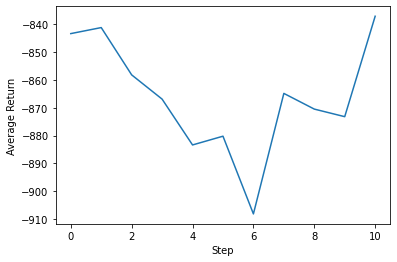

In [ ]:
#@test {"skip": true}

steps = range(0, 11, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [ ]:
for metric in collect_actor.metrics:
  print(f"{metric.name} = {metric.result()}")

NumberOfEpisodes = 0
EnvironmentSteps = 10
AverageReturn = 0.0
AverageEpisodeLength = 0.0


In [ ]:
collect_actor.metrics[2].result()

array(0., dtype=float32)